#import Libraries

In [ ]:
from PIL import Image, ImageDraw, ImageFilter
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report, auc
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# Import Dataset

In [ ]:
!git clone "https://github.com/hmda77/Machine-Learning-Class"
!mv "Machine-Learning-Class"/XGBoost/Persian_LPR/persian_LPR.zip ./
!rm -rf "Machine-Learning-Class"
!unzip persian_LPR.zip
!rm -rf persian_LPR.zip

Cloning into 'Machine-Learning-Class'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 163 (delta 17), reused 3 (delta 3), pack-reused 108
Receiving objects: 100% (163/163), 10.48 MiB | 206.00 KiB/s, done.
Resolving deltas: 100% (41/41), done.
Updating files: 100% (21/21), done.
Archive:  persian_LPR.zip
replace persian_LPR/2/100_13,96222_2616_8_0.82_2_18933 - Copy.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# Preproess on Dataset

In [ ]:
thumb_width = 16
input = []
label = []
for filename in glob.glob('persian_LPR/3/*.bmp'):
  im = Image.open(filename).convert('L')
  x = np.asarray(im).reshape(thumb_width**2)
  x = np.append(x,'3')
  input.append(x)

for filename in glob.glob('persian_LPR/2/*.bmp'):
  im = Image.open(filename).convert('L')
  x = np.asarray(im).reshape(thumb_width**2)
  x = np.append(x,'2')
  input.append(x)

for filename in glob.glob('persian_LPR/7/*.bmp'):
  im = Image.open(filename).convert('L')
  x = np.asarray(im).reshape(thumb_width**2)
  x = np.append(x,'7')
  input.append(x)
  
for filename in glob.glob('persian_LPR/W/*.bmp'):
  im = Image.open(filename).convert('L')
  x = np.asarray(im).reshape(thumb_width**2)
  x = np.append(x,'W')
  input.append(x)

for filename in glob.glob('persian_LPR/S/*.bmp'):
  im = Image.open(filename).convert('L')
  x = np.asarray(im).reshape(thumb_width**2)
  x = np.append(x,'S')
  input.append(x)

## Save Dataset as CSV File

In [ ]:
DF = pd.DataFrame(input)
DF.to_csv("Persian_LPR.csv")

In [ ]:
data = pd.read_csv("Persian_LPR.csv")
data.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,247,248,249,250,251,252,253,254,255,256
0,0,51,51,56,56,51,47,37,27,25,...,118,108,103,98,98,103,115,130,145,3
1,1,70,68,72,70,66,60,55,62,66,...,115,115,94,59,34,28,36,42,40,3
2,2,10,10,8,8,10,10,10,8,8,...,70,55,52,52,52,49,52,55,68,3
3,3,78,74,72,72,76,78,83,85,85,...,102,124,124,105,76,52,44,41,48,3
4,4,45,48,50,48,45,41,36,33,36,...,74,79,64,50,45,41,29,19,17,3


In [ ]:
data_classes = {'3':0, '2':1, '7':2, 'W':3,'S':4}

In [ ]:
data['label'] = data['256'].astype(str).str[0]

In [ ]:
data.loc[:, 'label'] = data.loc[:, 'label'].map(data_classes)

/tmp/ipykernel_733/2978893286.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, 'label'] = data.loc[:, 'label'].map(data_classes)


In [ ]:
data.drop(['256'], inplace = True, axis = 1)

In [ ]:
data.isnull().sum()

Unnamed: 0    0
0             0
1             0
2             0
             ..
253           0
254           0
255           0
label         0
Length: 258, dtype: int64

In [ ]:
data.to_csv("Persian_LPR.csv")

In [ ]:
data = pd.read_csv("Persian_LPR.csv")
data.head(5)

,Unnamed: 0.1,Unnamed: 0,0,1,2,3,4,5,6,7,...,247,248,249,250,251,252,253,254,255,label
0,0,0,51,51,56,56,51,47,37,27,...,118,108,103,98,98,103,115,130,145,0
1,1,1,70,68,72,70,66,60,55,62,...,115,115,94,59,34,28,36,42,40,0
2,2,2,10,10,8,8,10,10,10,8,...,70,55,52,52,52,49,52,55,68,0
3,3,3,78,74,72,72,76,78,83,85,...,102,124,124,105,76,52,44,41,48,0
4,4,4,45,48,50,48,45,41,36,33,...,74,79,64,50,45,41,29,19,17,0


## Split Train Test

In [ ]:
# split data & label
X_train = data.iloc[:, 1:-1].values.astype(np.float32)
Y_train = data.iloc[:, -1].values


# make Train & validation set
train_set, test_set, train_labels, test_labels = train_test_split(X_train, Y_train, random_state= 231,test_size=0.10)

In [ ]:
unique, counts = np.unique(Y_train, return_counts=True)
for i,x in enumerate(data_classes):
    print('{} counts: {}'.format(x,counts[i]))

3 counts: 300
2 counts: 300
7 counts: 300
W counts: 300
S counts: 300


In [ ]:
print(train_set.shape,test_set.shape)
print(train_labels.shape,test_labels.shape)

(1350, 256) (150, 256)
(1350,) (150,)


In [ ]:
sample_image = train_set[1].reshape(thumb_width,thumb_width)
sample_image.shape

(16, 16)

## Show random pictures

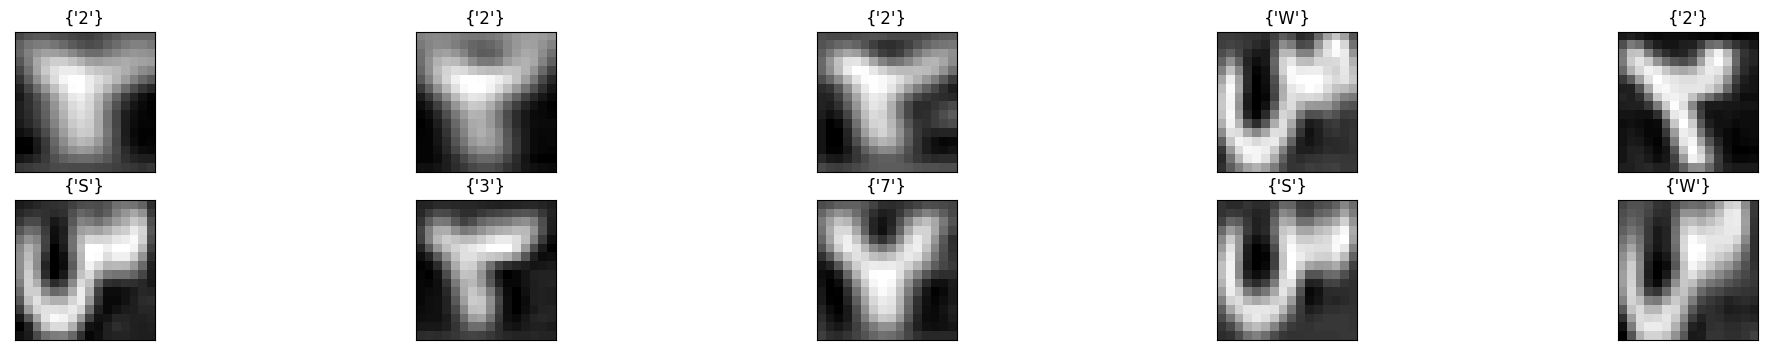

In [ ]:
fig=plt.figure(figsize=(25,4))
for i in range(1,11):
    ax=fig.add_subplot(2,5,i,xticks=[],yticks=[])
    ax.imshow(train_set[i].reshape(thumb_width,thumb_width),cmap='gray')
    ax.set_title({j for j in data_classes if data_classes[j]==train_labels[i]})

# Metric Functions

In [ ]:
# Make the confusion matrix
def confusion_plot(y_test,y_pred,title):
    cmt = confusion_matrix(y_test,y_pred)
    plt.rcParams['figure.figsize'] = (10,8)
    sns.heatmap(cmt,fmt='',annot=True,linewidth=0.01,cmap=sns.cubehelix_palette(as_cmap=True))
    plt.title("confusion matrix {}".format(title))
    plt.xlabel("predicted")
    plt.ylabel("true")
    plt.show()


# generate classification report
def generate_classification_report(y_test,y_pred):
    report=pd.DataFrame.from_dict(classification_report(y_pred,y_test,output_dict=True)).T
    # report['Label']=[data_classes[i]  if i<5 else " " for i,x in enumerate(report.index)]
    report=report[['f1-score','precision','recall','support']]
    pd.set_option('display.max_rows', report.shape[0]+1)
    return report

# ROC Curve
def plot_roc_curve(y_test,proba,pos_label):
    fpr, tpr, thresholds = roc_curve(y_test, proba[:,pos_label], pos_label= pos_label)
    roc_auc = roc_auc_score(y_test, proba, multi_class='ovr')

    plt.rcParams['figure.figsize'] = (5,4)
    plt.plot(fpr, tpr,'k:',lw=5, label='average ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0 ,1],[0 ,1],'r')
    plt.legend(loc="lower right")
    plt.title('ROC Curve for calss {0}'.format(data_classes[pos_label]))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


# ROC Curve for all classes
def plot_roc_curve_all(y_test,proba,n_class,title):
    for i in range(n_class):
      fpr, tpr, thresholds = roc_curve(y_test, proba[:,i],pos_label= i)
      plt.plot(fpr, tpr,lw=1)
    plt.plot([0 ,1],[0 ,1],'r')
    plt.title('ROC Curve for all classes in {}'.format(title))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(data_classes)
    plt.show()

# Train XGBoost Model

In [ ]:
model = XGBClassifier()
model.fit(train_set, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
y_pred = model.predict(test_set)

## Metric Results

In [ ]:
generate_classification_report(test_labels, y_pred)

,f1-score,precision,recall,support
0,0.965517,0.933333,1.000000,28.000000
1,0.920635,0.966667,0.878788,33.000000
2,0.949153,0.933333,0.965517,29.000000
3,0.965517,0.933333,1.000000,28.000000
4,0.967742,1.000000,0.937500,32.000000
accuracy,0.953333,0.953333,0.953333,0.953333
macro avg,0.953713,0.953333,0.956361,150.000000
weighted avg,0.952954,0.954889,0.953333,150.000000


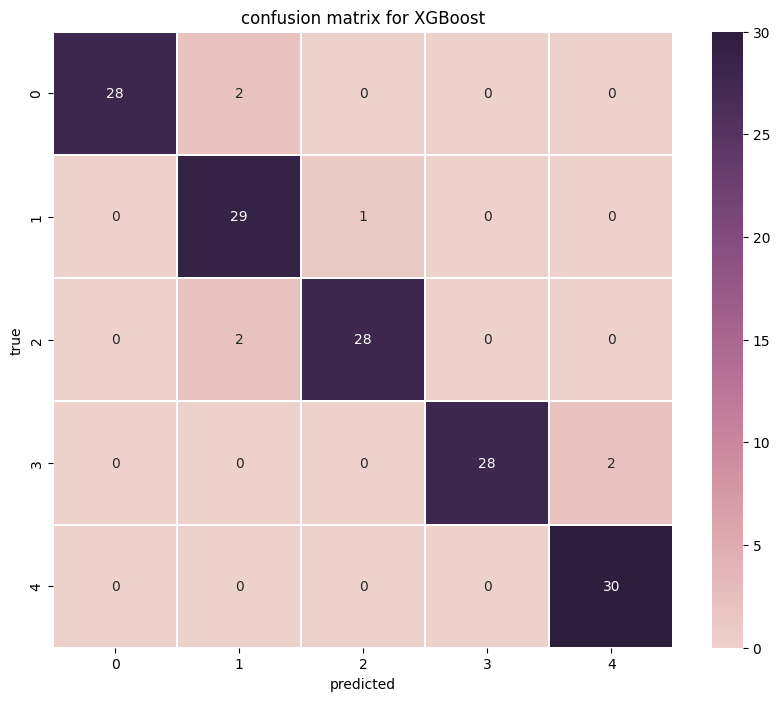

In [ ]:
confusion_plot(test_labels,y_pred,'for XGBoost')

# Fine-Tunning

In [ ]:
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': range(8, 20),
    'max_depth': range(6, 10),
    'learning_rate': [.4, .45, .5, .55, .6],
    'colsample_bytree': [.6, .7, .8, .9, 1]
}

# Instantiate the regressor: gbm
gbm = XGBClassifier(n_estimators=10)

# Perform random search: grid_mse
xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid, 
                                    estimator = gbm, scoring = "accuracy", 
                                    verbose = 1, n_iter = 50, cv = 4)


# Fit randomized_mse to the data
xgb_random.fit(X_train, Y_train)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", xgb_random.best_params_)
print("Best accuracy found: ", xgb_random.best_score_)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best parameters found:  {'n_estimators': 17, 'max_depth': 7, 'learning_rate': 0.6, 'colsample_bytree': 0.8}
Best accuracy found:  0.9413333333333334


In [ ]:
y_pred = xgb_random.predict(test_set)

## Result for best Model

In [ ]:
generate_classification_report(test_labels, y_pred)

,f1-score,precision,recall,support
0,1.0,1.0,1.0,30.0
1,1.0,1.0,1.0,30.0
2,1.0,1.0,1.0,30.0
3,1.0,1.0,1.0,30.0
4,1.0,1.0,1.0,30.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,150.0
weighted avg,1.0,1.0,1.0,150.0


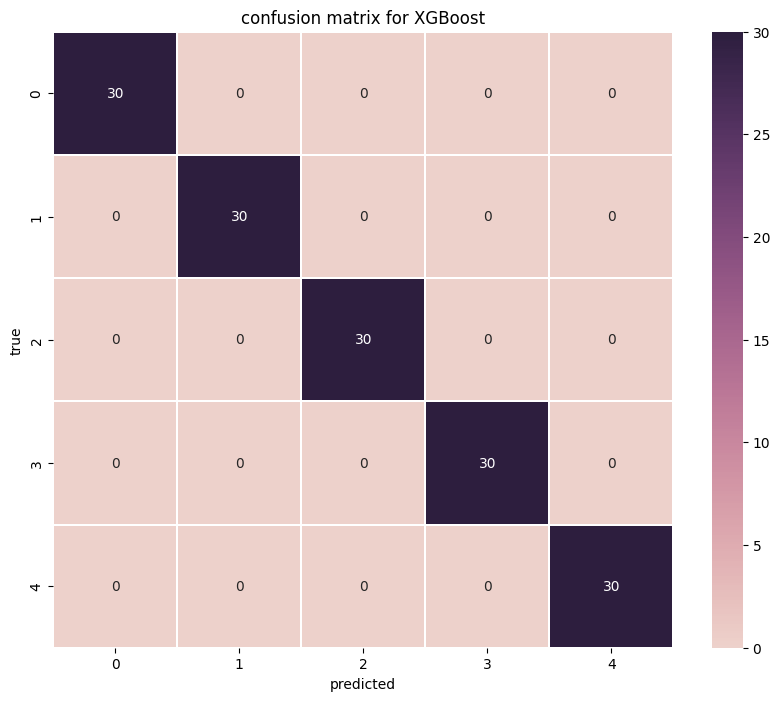

In [ ]:
confusion_plot(test_labels,y_pred,'for XGBoost')